Initial Data Overview:
   GridId              Toid  GRID_ExactCut_ID Location_ExactCut  \
0    6256  4000000027865913                27            NonGLA   
1    6428  4000000027865913                45            NonGLA   
2    6600  4000000027865913                74            NonGLA   
3    6772  4000000027865913               106            NonGLA   
4    6256  4000000027865914                27            NonGLA   

  BoroughName_ExactCut  LTS ID  Length (m) Emissions  Year Pollutant  ...  \
0               NonGLA   16001  117.662736       DFT  2010       CO2  ...   
1               NonGLA   16001  504.845737       DFT  2010       CO2  ...   
2               NonGLA   16001  511.909513       DFT  2010       CO2  ...   
3               NonGLA   16001   51.510888       DFT  2010       CO2  ...   
4               NonGLA   16001  114.435065       DFT  2010       CO2  ...   

   Diesel Car  Electric Car  Petrol LGV  Diesel LGV  Electric LGV    TfL Bus  \
0  145.787661             0    

C:\Users\Adil\AppData\Local\Temp\ipykernel_2128\2492817778.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(data[column].mean(), inplace=True)
C:\Users\Adil\AppData\Local\Temp\ipykernel_2128\2492817778.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For


Training Random Forest...
Random Forest Evaluation Completed in 708.64 seconds.
Mean Squared Error: 118.00166366608123
Mean Absolute Error: 1.035208823297175
R2 Score: 0.9933538440835353

Training Decision Tree...
Decision Tree Evaluation Completed in 15.02 seconds.
Mean Squared Error: 221.673445900169
Mean Absolute Error: 1.4548895774185877
R2 Score: 0.9875147837901542

Training XGBoost...
XGBoost Evaluation Completed in 7.38 seconds.
Mean Squared Error: 1008.336763297055
Mean Absolute Error: 1.9843909355379463
R2 Score: 0.9432078909994053

Total Processing Time: 731.90 seconds.

Model Comparison Results:
               Mean Squared Error  Mean Absolute Error  R2 Score
Random Forest          118.001664             1.035209  0.993354
Decision Tree          221.673446             1.454890  0.987515
XGBoost               1008.336763             1.984391  0.943208


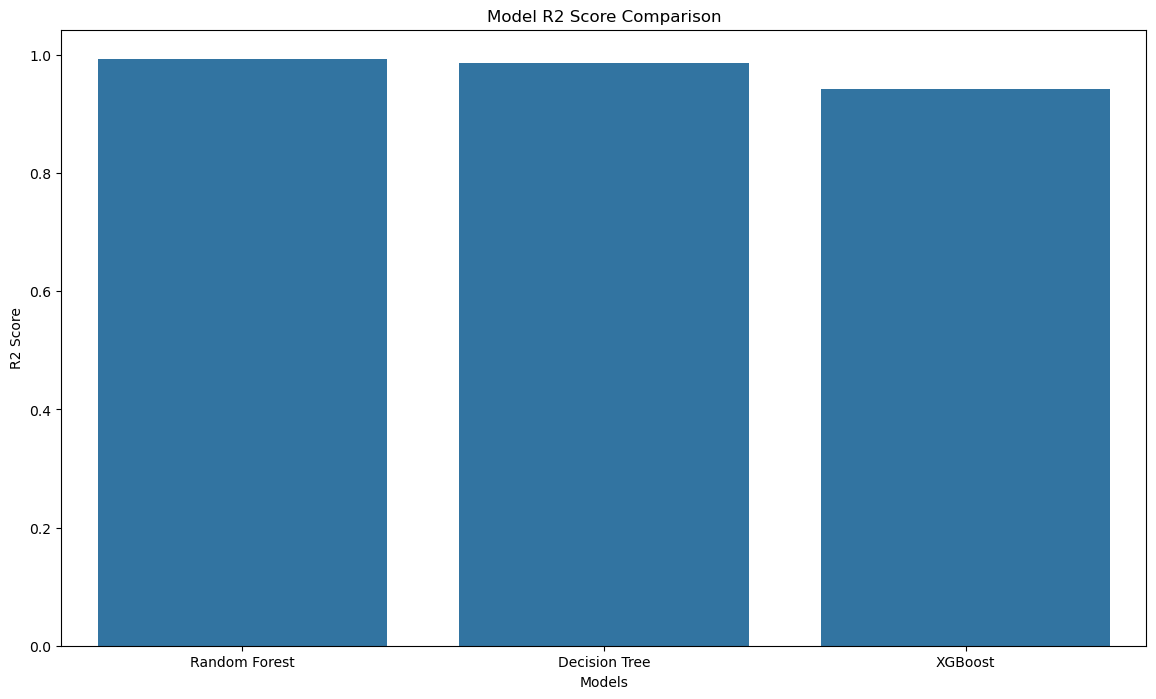

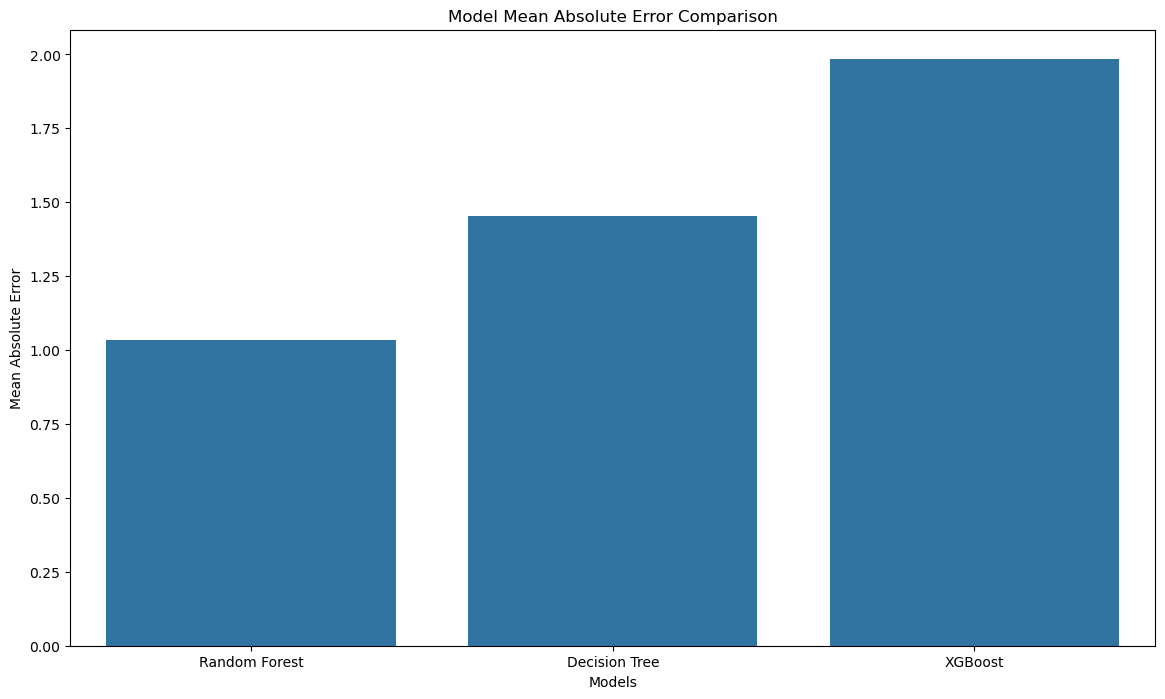

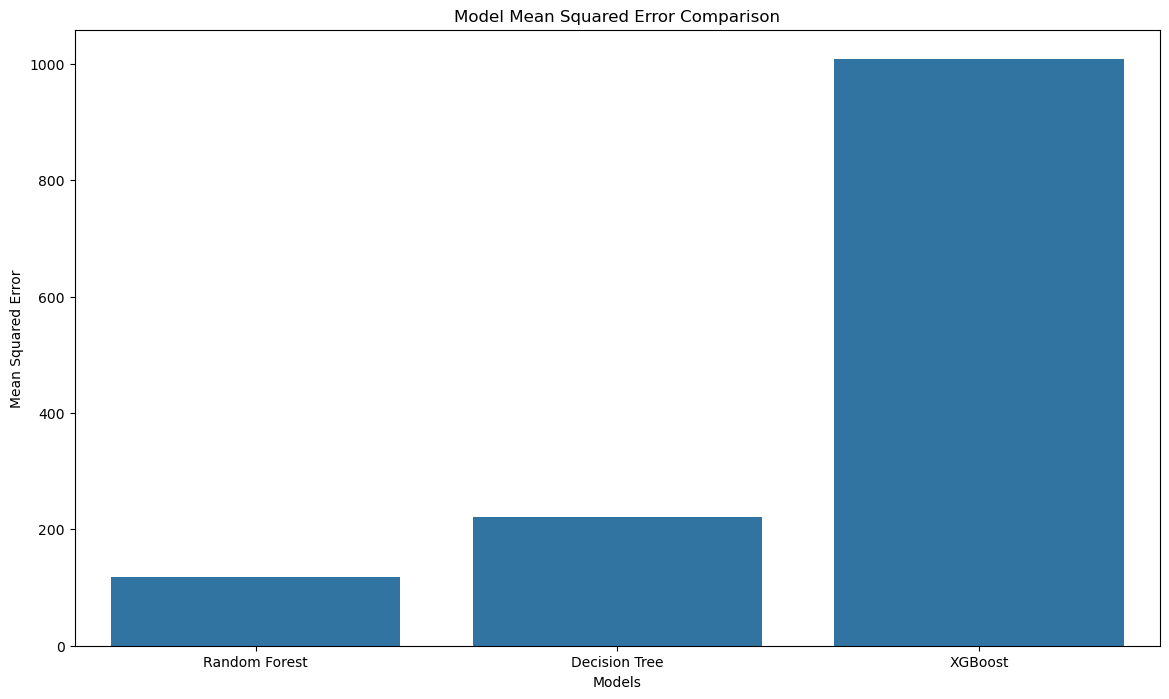


Predictions for Random Forest saved to Random Forest_predictions_with_pollutant_names.csv
        GridId              Toid  GRID_ExactCut_ID Location_ExactCut  \
120400    9206  4000000030255460              1465             Inner   
117961   10582  4000000030237384              1618             Inner   
32363    10579  4000000030417689               934             Inner   
173375    9517  4000000030310515              2180             Outer   
344280   10728  4000000030451739              2974             Outer   

       BoroughName_ExactCut  LTS ID  Length (m) Emissions  Year     Pollutant  \
120400               Newham   28406  120.908970    COPERT  2010    PM10_Brake   
117961             Lewisham    7559  125.357018    COPERT  2010    PM10_Brake   
32363              Lewisham   48557   14.606616       DFT  2010           CO2   
173375           Hillingdon   56742   13.296427    COPERT  2010  PM10_Exhaust   
344280             Hounslow   56869    6.181417    COPERT  2010    PM25

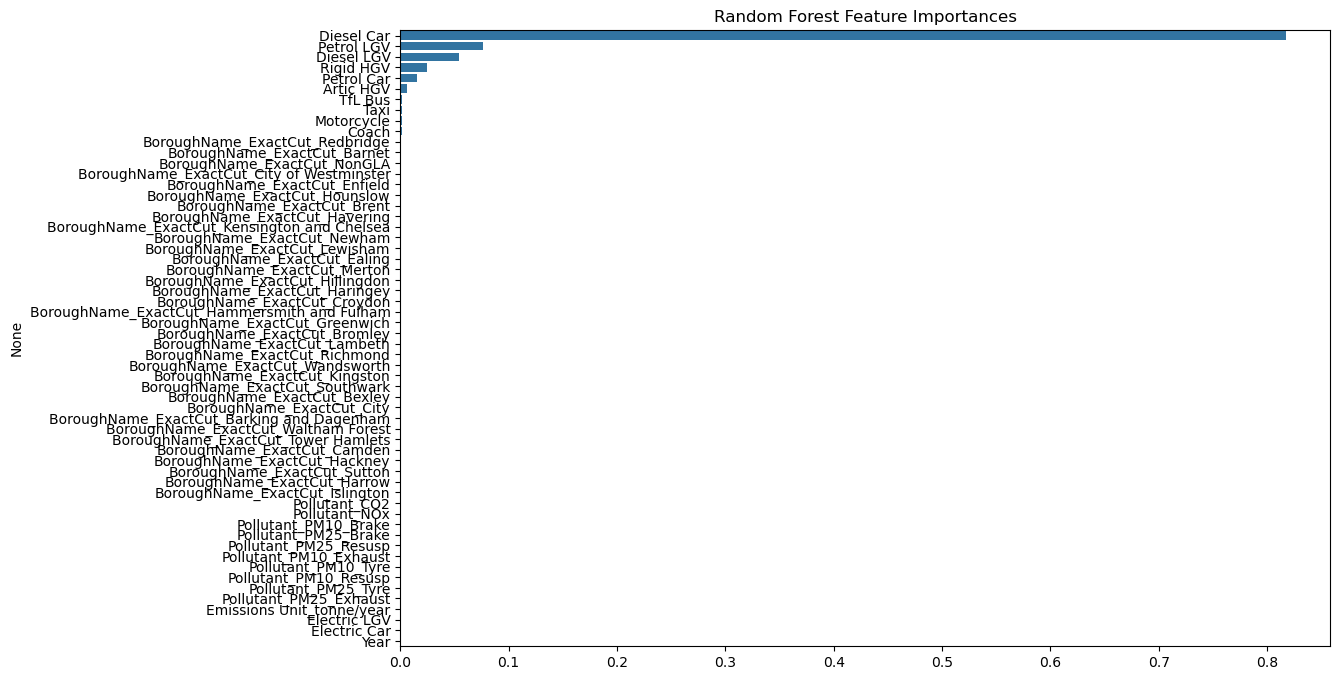


Feature importances for Decision Tree saved to Decision Tree_feature_importances.csv


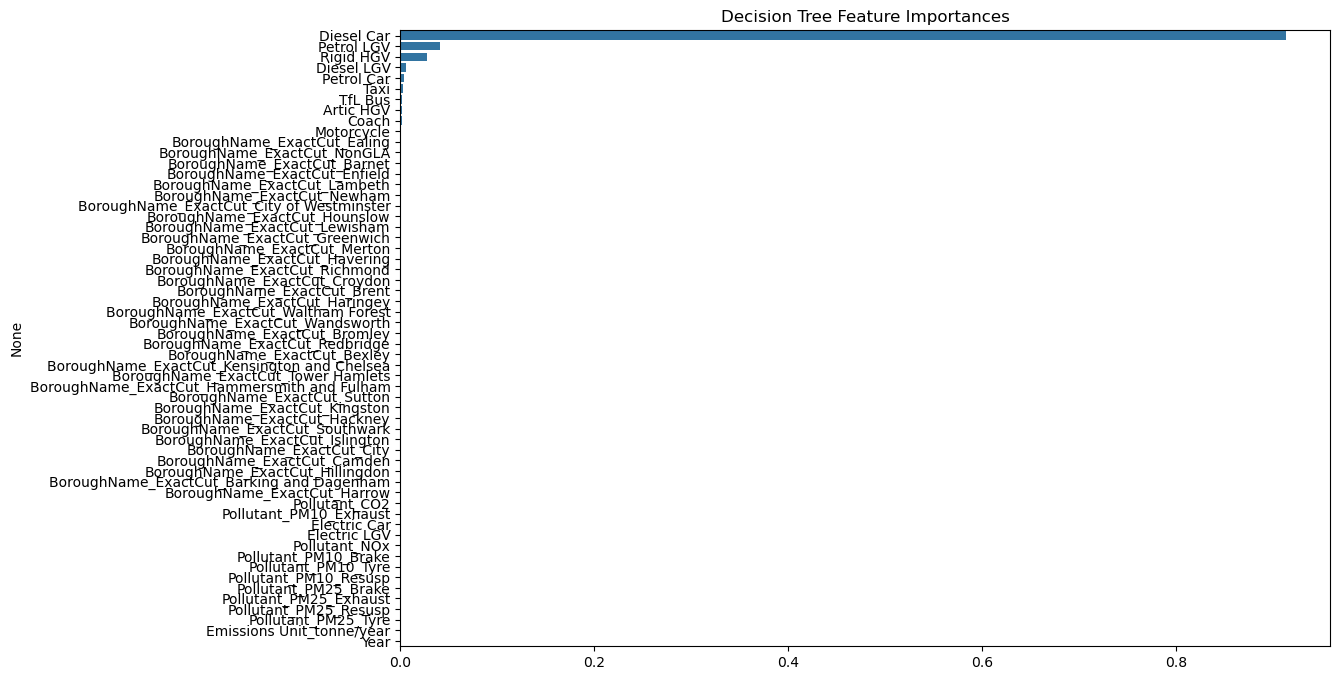


Feature importances for XGBoost saved to XGBoost_feature_importances.csv


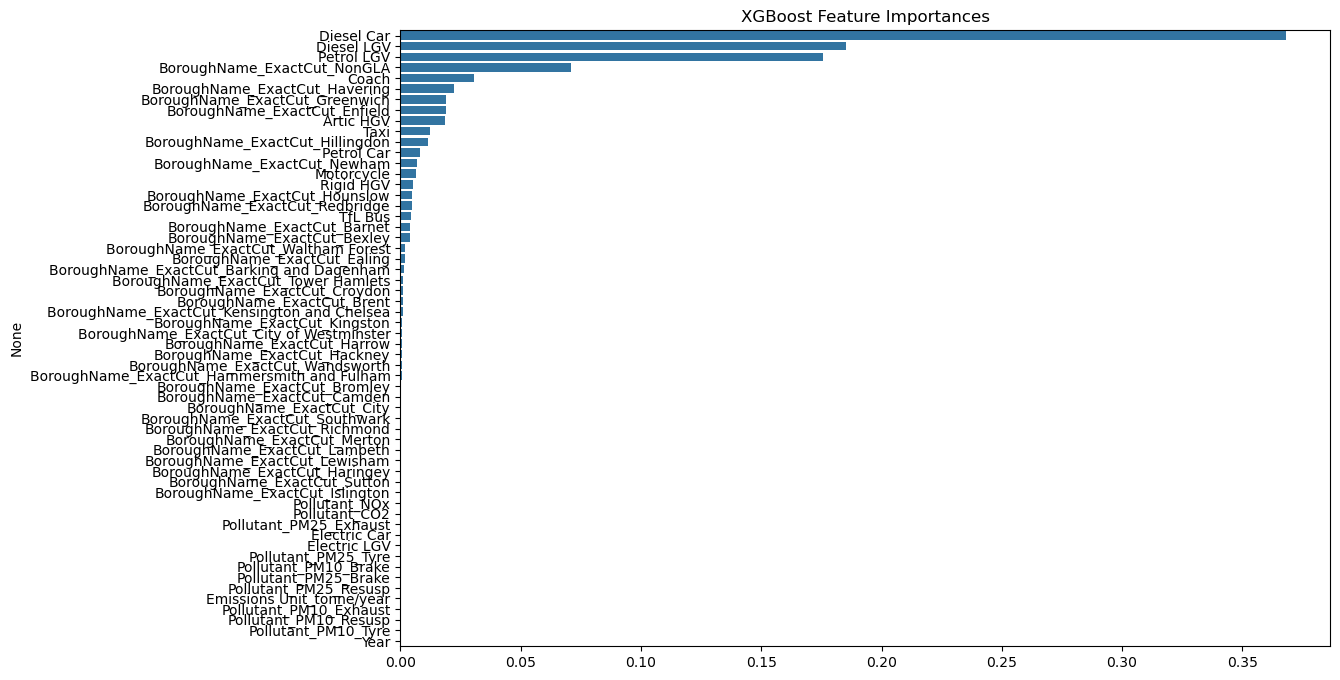

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Step 1: Load and Inspect the Data
data = pd.read_excel(r"D:\New folder\Modified_Road_2010.xlsx")
print("Initial Data Overview:")
print(data.head())
print(data.info())

# Step 2: Preprocessing
start_time = time.time()

# Handle missing values
for column in data.columns:
    if data[column].dtype == 'object':  # Categorical columns
        data[column].fillna(data[column].mode()[0], inplace=True)
    else:  # Numerical columns
        data[column].fillna(data[column].mean(), inplace=True)

data['Year'] = data['Year'].astype(int)  # Ensure 'Year' is integer

# Step 3: Define Features and Target
X = data.drop(columns=['Total'])
y = data['Total']  # Target variable

categorical_features = ['Pollutant', 'Emissions Unit', 'BoroughName_ExactCut']
numerical_features = ['Year', 'Motorcycle', 'Taxi', 'Petrol Car', 'Diesel Car',
                      'Electric Car', 'Petrol LGV', 'Diesel LGV', 'Electric LGV',
                      'TfL Bus', 'Coach', 'Rigid HGV', 'Artic HGV']

# Step 4: Column Transformer and Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),          # Scale numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # One-hot encode categorical features
    ])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=X['Pollutant'])

# Define models with improved settings
models = {
    'Random Forest': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42, n_jobs=-1))
    ]),
    'Decision Tree': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', DecisionTreeRegressor(max_depth=15, random_state=42))
    ]),
    'XGBoost': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', XGBRegressor(n_estimators=500, max_depth=8, learning_rate=0.05, subsample=0.8,
                               colsample_bytree=0.8, random_state=42, verbosity=0, n_jobs=-1))
    ])
}

# Dictionary to store results for comparison
model_results = {}
predictions_dict = {}
feature_importance_dict = {}

# Step 5: Training, Prediction, and Evaluation
for model_name, pipeline in models.items():
    model_start_time = time.time()
    print(f"\nTraining {model_name}...")

    # Train the model
    pipeline.fit(X_train, y_train)

    # Make predictions
    predictions = pipeline.predict(X_test)

    # Evaluation Metrics
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    # Store results
    model_results[model_name] = {
        'Mean Squared Error': mse,
        'Mean Absolute Error': mae,
        'R2 Score': r2
    }

    # Store predictions
    predictions_dict[model_name] = predictions

    # Extract feature importances
    if model_name == 'XGBoost':
        feature_importances = pipeline.named_steps['model'].feature_importances_
    else:
        feature_importances = pipeline.named_steps['model'].feature_importances_

    # Combine feature names from numerical and categorical features
    feature_names = (numerical_features +
                     list(pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)))

    # Store feature importances
    feature_importance_dict[model_name] = pd.Series(feature_importances, index=feature_names)

    print(f"{model_name} Evaluation Completed in {time.time() - model_start_time:.2f} seconds.")
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R2 Score: {r2}")

# Total time for the entire process
print(f"\nTotal Processing Time: {time.time() - start_time:.2f} seconds.")

# Step 6: Visualization of Model Evaluation Results
results_df = pd.DataFrame(model_results).T
print("\nModel Comparison Results:")
print(results_df)

# Plotting R2 Score
plt.figure(figsize=(14, 8))
sns.barplot(x=results_df.index, y='R2 Score', data=results_df)
plt.title('Model R2 Score Comparison')
plt.ylabel('R2 Score')
plt.xlabel('Models')
plt.show()

# Plotting Mean Absolute Error
plt.figure(figsize=(14, 8))
sns.barplot(x=results_df.index, y='Mean Absolute Error', data=results_df)
plt.title('Model Mean Absolute Error Comparison')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Models')
plt.show()

# Plotting Mean Squared Error
plt.figure(figsize=(14, 8))
sns.barplot(x=results_df.index, y='Mean Squared Error', data=results_df)
plt.title('Model Mean Squared Error Comparison')
plt.ylabel('Mean Squared Error')
plt.xlabel('Models')
plt.show()

# Step 7: Save All Models' Performance Predictions and Feature Importances to CSV
for model_name, predictions in predictions_dict.items():
    results_with_pollutant = X_test.copy()
    results_with_pollutant['Actual_Total'] = y_test
    results_with_pollutant['Predicted_Total'] = predictions

    output_filename = f'{model_name}_predictions_with_pollutant_names.csv'
    results_with_pollutant.to_csv(output_filename, index=False)
    print(f"\nPredictions for {model_name} saved to {output_filename}")
    print(results_with_pollutant.head())

# Save feature importances
for model_name, feature_importances in feature_importance_dict.items():
    feature_importances.sort_values(ascending=False, inplace=True)
    feature_importances.to_csv(f'{model_name}_feature_importances.csv', index=True)
    print(f"\nFeature importances for {model_name} saved to {model_name}_feature_importances.csv")

    # Plot feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x=feature_importances.values, y=feature_importances.index)
    plt.title(f'{model_name} Feature Importances')
    plt.show()


Visualizations for Random Forest


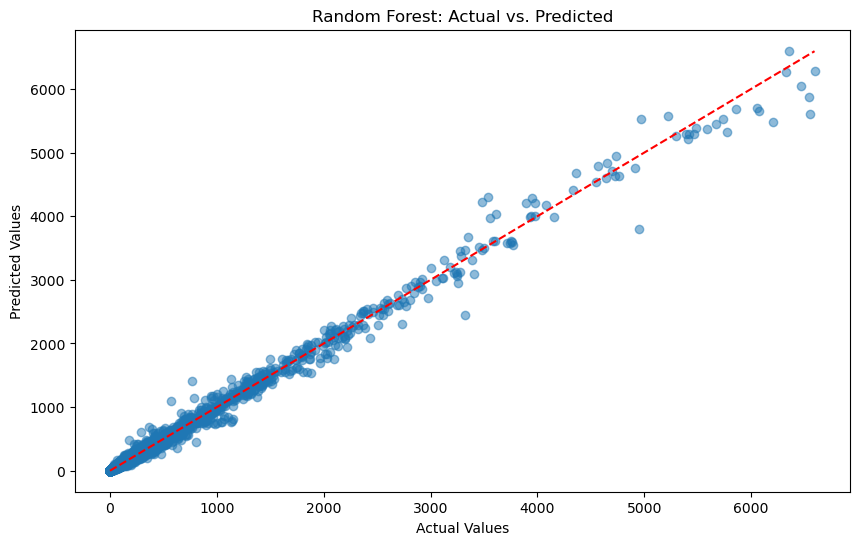

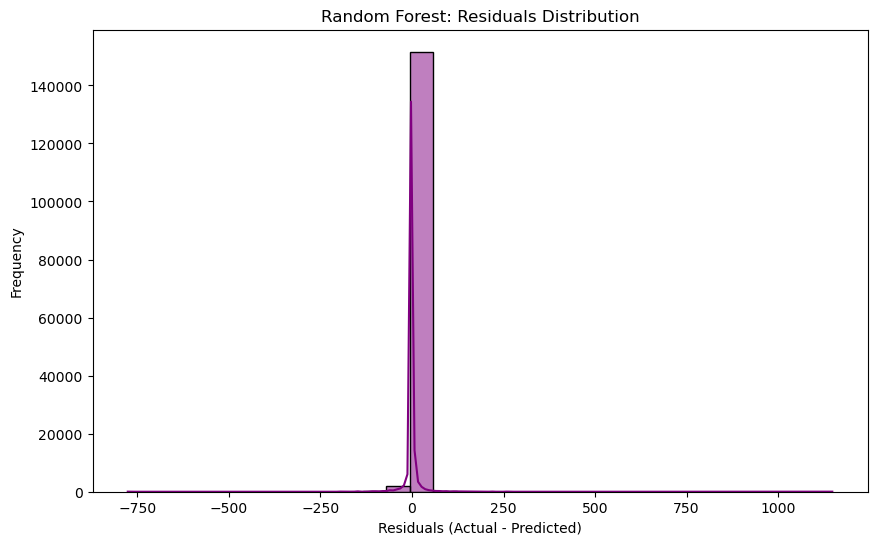

C:\Users\Adil\AppData\Local\Temp\ipykernel_2128\1520866038.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances.values, y=feature_importances.index, palette='viridis')


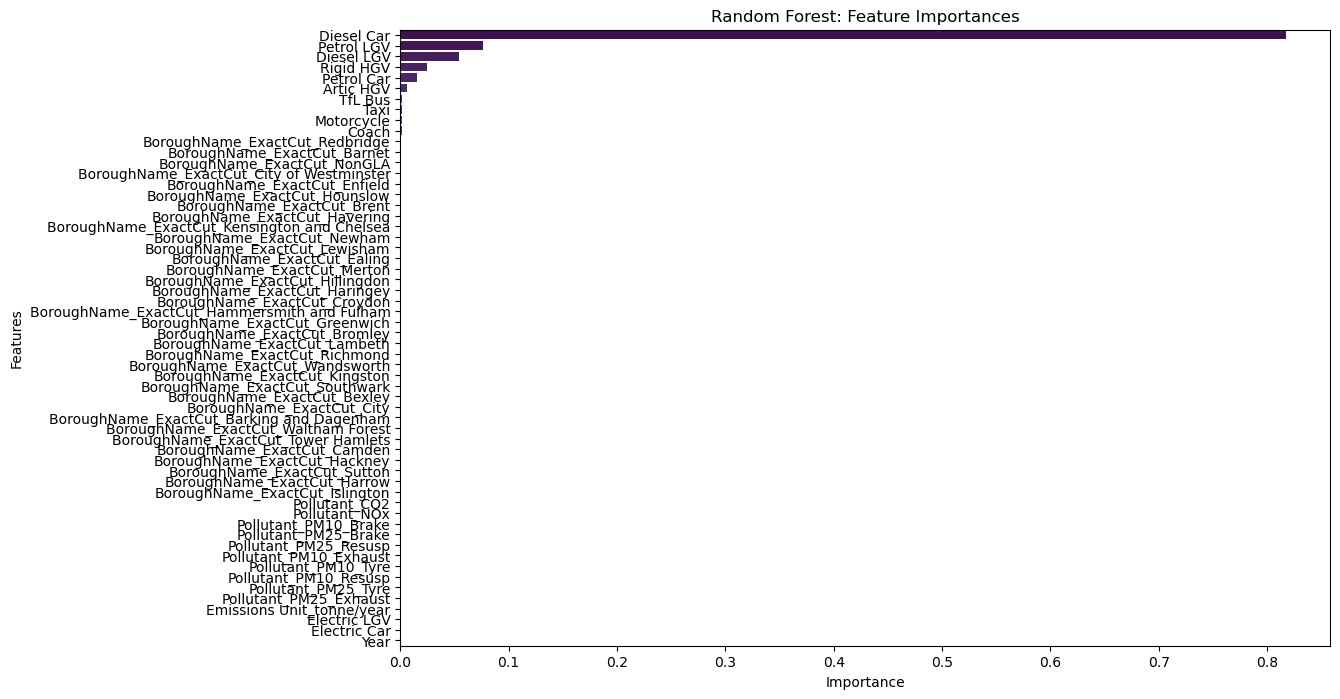

Visualizations for Decision Tree


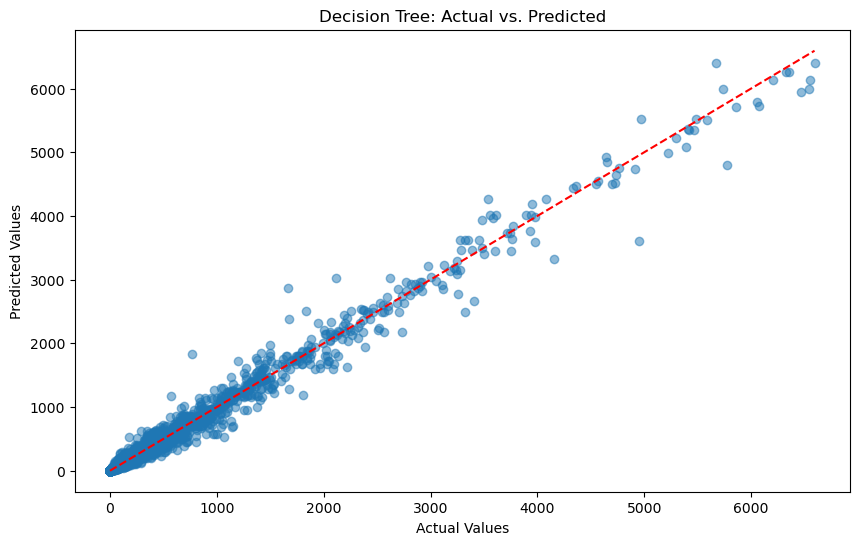

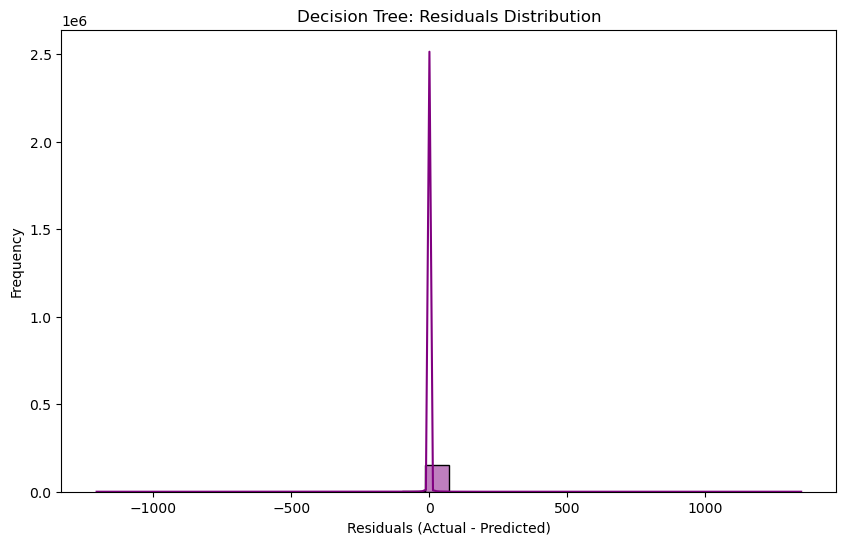

C:\Users\Adil\AppData\Local\Temp\ipykernel_2128\1520866038.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances.values, y=feature_importances.index, palette='viridis')


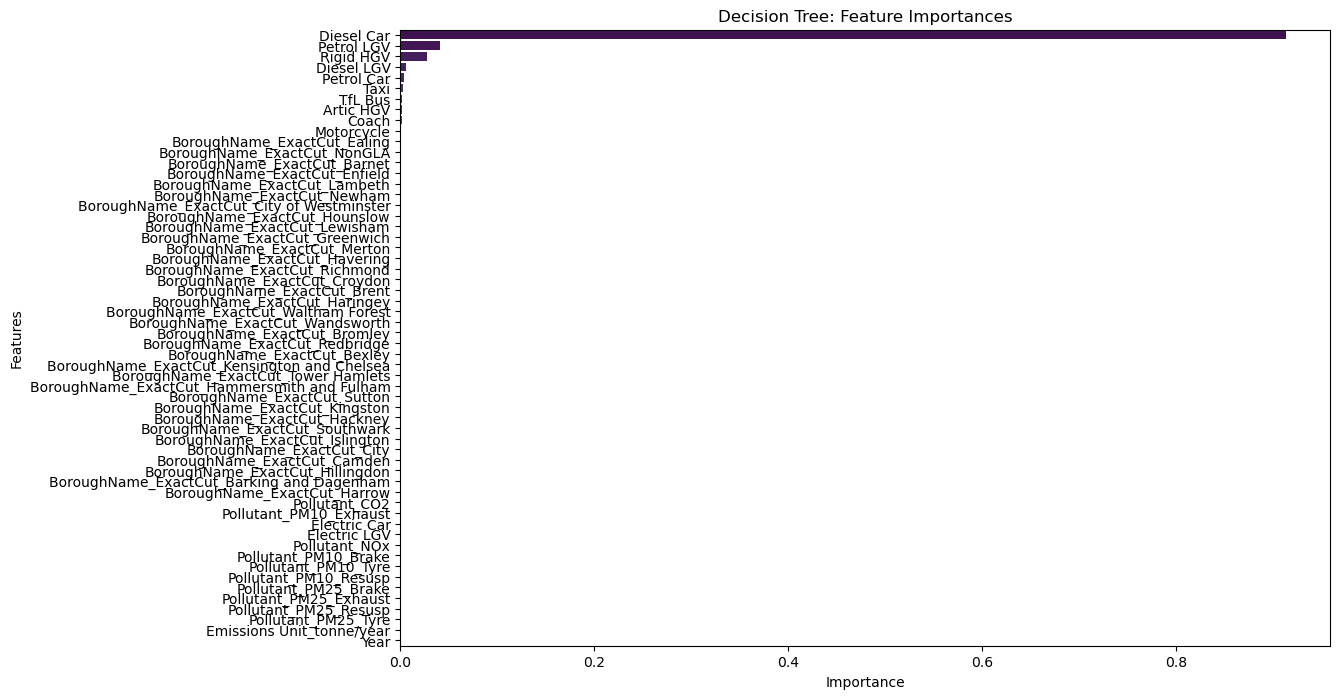

Visualizations for XGBoost


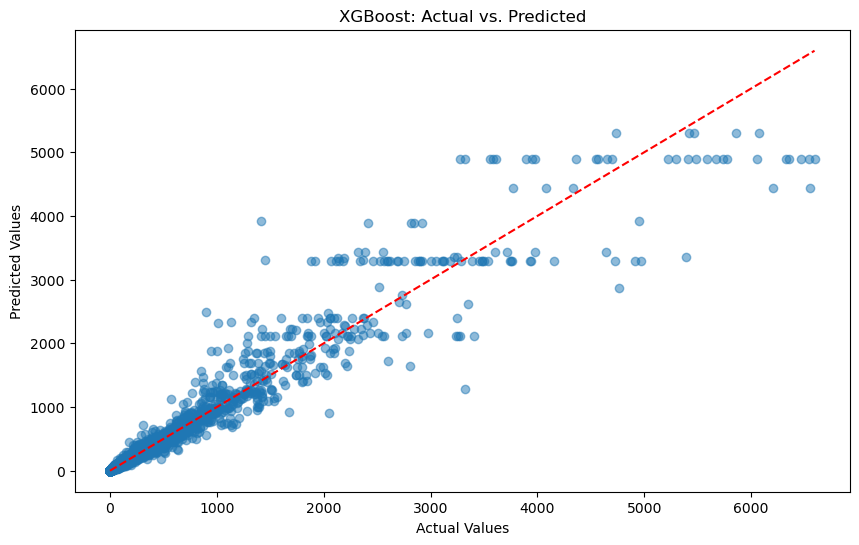

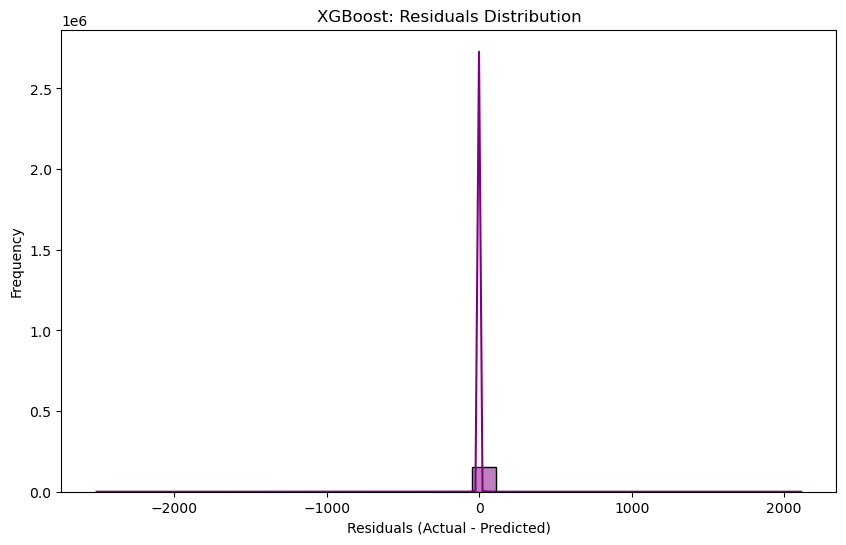

C:\Users\Adil\AppData\Local\Temp\ipykernel_2128\1520866038.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances.values, y=feature_importances.index, palette='viridis')


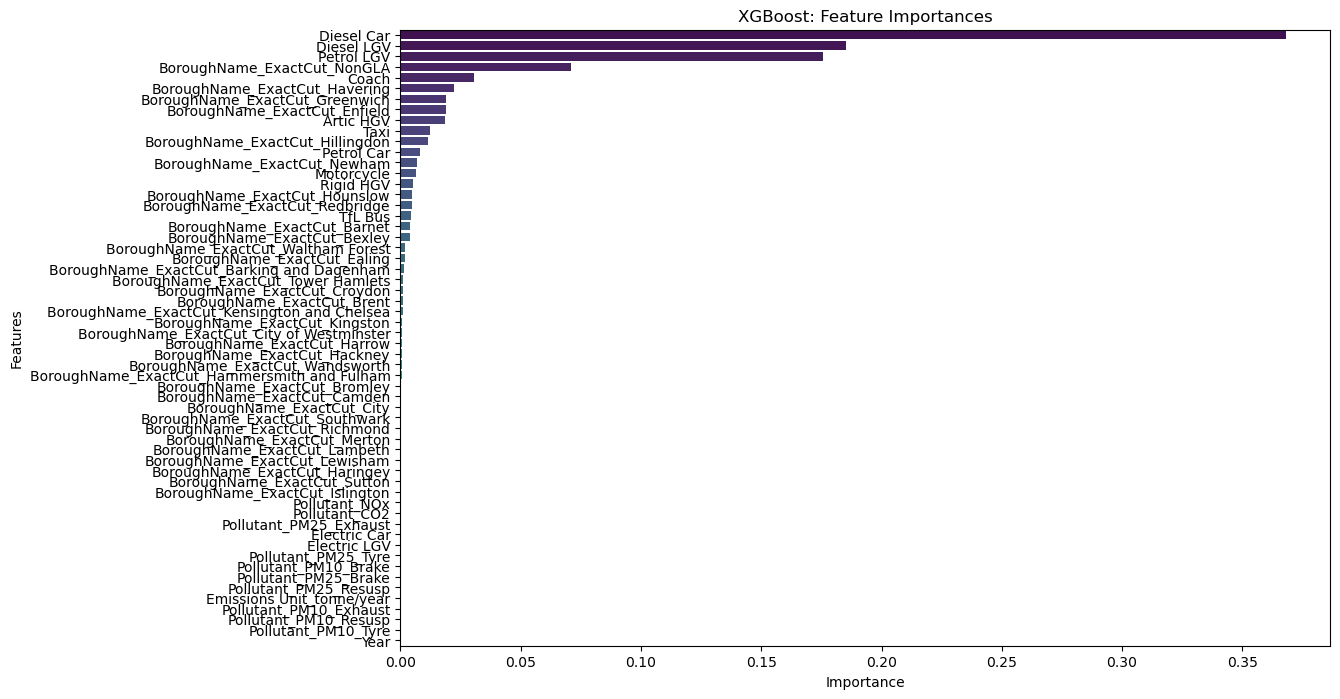

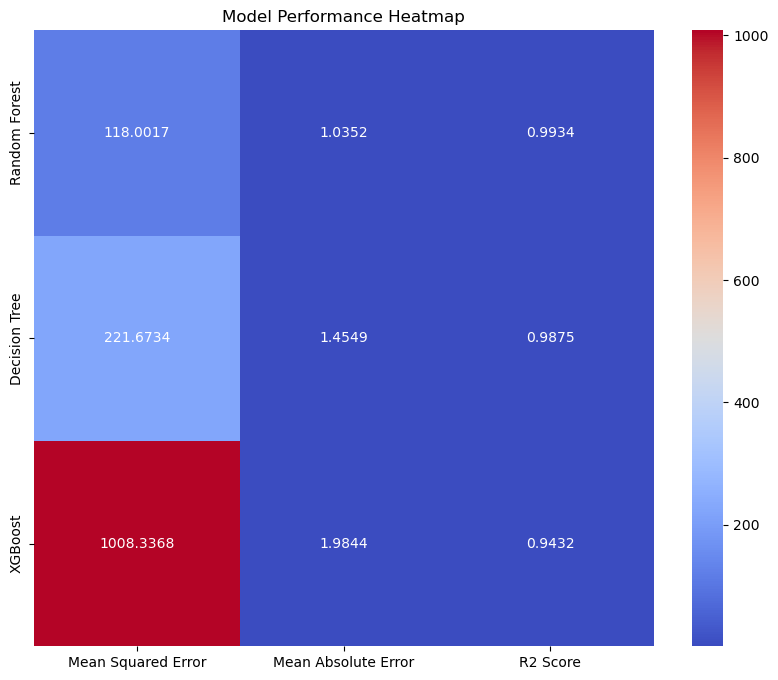

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Function to create scatter plots, heatmaps, and other visualizations
def create_visualizations(model_name, y_test, predictions, feature_importances=None):
    # Scatter plot for Actual vs. Predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, predictions, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Reference line
    plt.title(f'{model_name}: Actual vs. Predicted')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()

    # Residuals plot (Actual - Predicted)
    residuals = y_test - predictions
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True, bins=30, color='purple')
    plt.title(f'{model_name}: Residuals Distribution')
    plt.xlabel('Residuals (Actual - Predicted)')
    plt.ylabel('Frequency')
    plt.show()

    # If feature importances are provided, plot them
    if feature_importances is not None:
        plt.figure(figsize=(12, 8))
        sns.barplot(x=feature_importances.values, y=feature_importances.index, palette='viridis')
        plt.title(f'{model_name}: Feature Importances')
        plt.xlabel('Importance')
        plt.ylabel('Features')
        plt.show()

# Plot Heatmap for Model Performance
def plot_performance_heatmap(results_df):
    plt.figure(figsize=(10, 8))
    sns.heatmap(results_df, annot=True, cmap='coolwarm', fmt='.4f')
    plt.title('Model Performance Heatmap')
    plt.show()

# Assuming `model_results`, `predictions_dict`, and `feature_importance_dict` are defined from the previous step

# Step 1: Create scatter plots and other visualizations for each model
for model_name in predictions_dict.keys():
    print(f"Visualizations for {model_name}")
    create_visualizations(
        model_name,
        y_test,
        predictions_dict[model_name],
        feature_importances=feature_importance_dict.get(model_name)
    )

# Step 2: Plot heatmap for model performance
plot_performance_heatmap(results_df)



Initial Data Overview:
   GridId              Toid  GRID_ExactCut_ID Location_ExactCut  \
0    6256  4000000027865913                27            NonGLA   
1    6428  4000000027865913                45            NonGLA   
2    6600  4000000027865913                74            NonGLA   
3    6772  4000000027865913               106            NonGLA   
4    6256  4000000027865914                27            NonGLA   

  BoroughName_ExactCut  LTS ID  Length (m) Emissions  Year Pollutant  ...  \
0               NonGLA   16001  117.662736       DFT  2010       CO2  ...   
1               NonGLA   16001  504.845737       DFT  2010       CO2  ...   
2               NonGLA   16001  511.909513       DFT  2010       CO2  ...   
3               NonGLA   16001   51.510888       DFT  2010       CO2  ...   
4               NonGLA   16001  114.435065       DFT  2010       CO2  ...   

   Diesel Car  Electric Car  Petrol LGV  Diesel LGV  Electric LGV    TfL Bus  \
0  145.787661             0    

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



Training Best Neural Network Model...
Epoch 1/100
8991/8991 - 41s - 5ms/step - loss: 11340.7539 - mae: 16.1284 - val_loss: 1737.5848 - val_mae: 9.5893 - learning_rate: 1.0000e-04
Epoch 2/100
8991/8991 - 39s - 4ms/step - loss: 9772.3340 - mae: 15.9172 - val_loss: 7479.0474 - val_mae: 12.4849 - learning_rate: 1.0000e-04
Epoch 3/100
8991/8991 - 43s - 5ms/step - loss: 8480.5596 - mae: 16.3967 - val_loss: 72643.6094 - val_mae: 22.4766 - learning_rate: 1.0000e-04
Epoch 4/100
8991/8991 - 42s - 5ms/step - loss: 7420.7163 - mae: 17.0425 - val_loss: 481202.2188 - val_mae: 37.1370 - learning_rate: 1.0000e-04
Epoch 5/100
8991/8991 - 41s - 5ms/step - loss: 6507.7666 - mae: 18.1111 - val_loss: 709289.5625 - val_mae: 46.2907 - learning_rate: 1.0000e-04
Epoch 6/100
8991/8991 - 39s - 4ms/step - loss: 5848.9575 - mae: 19.2515 - val_loss: 585464.1250 - val_mae: 42.7249 - learning_rate: 1.0000e-04
Epoch 7/100
8991/8991 - 40s - 4ms/step - loss: 5309.6411 - mae: 20.0821 - val_loss: 163187.9531 - val_mae: 3

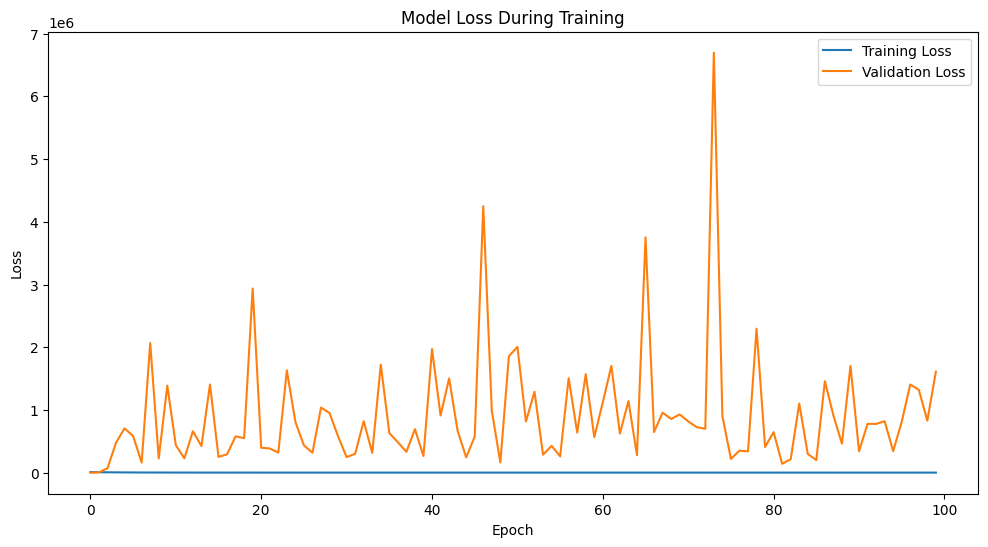

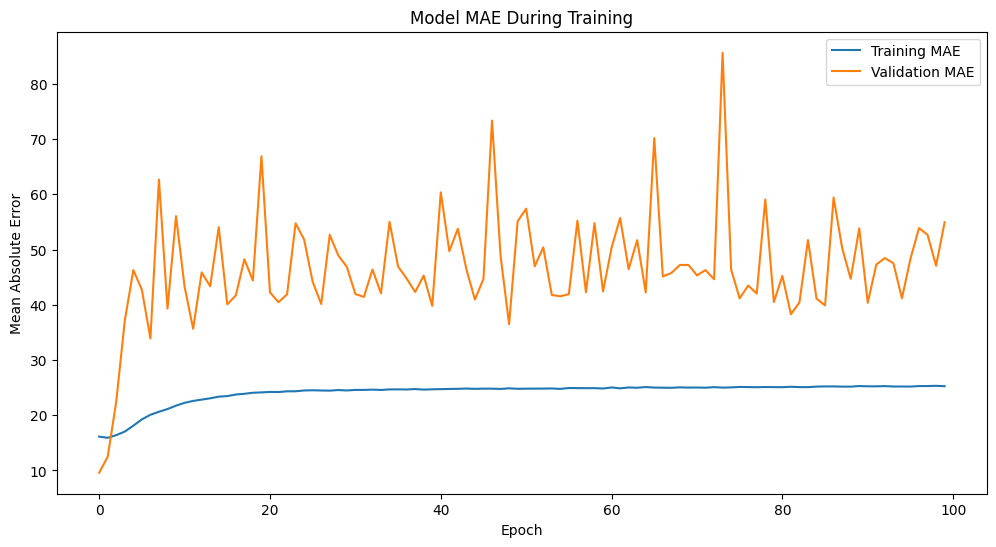


Model Comparison Results:
                Mean Squared Error  Mean Absolute Error  R2 Score
Neural Network         1577.678614             9.348476  0.911141


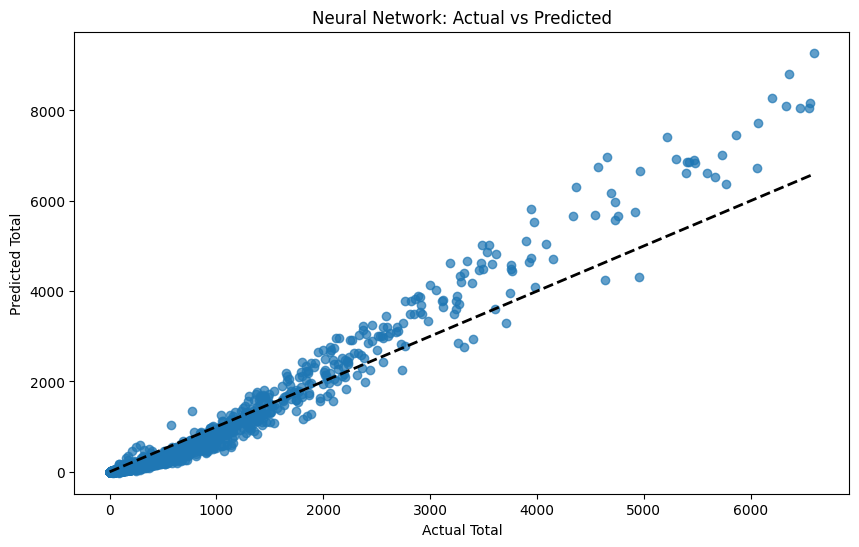


Predictions saved to Neural_Network_predictions_with_pollutant_names.csv
        GridId              Toid  GRID_ExactCut_ID Location_ExactCut  \
120400    9206  4000000030255460              1465             Inner   
117961   10582  4000000030237384              1618             Inner   
32363    10579  4000000030417689               934             Inner   
173375    9517  4000000030310515              2180             Outer   
344280   10728  4000000030451739              2974             Outer   

       BoroughName_ExactCut  LTS ID  Length (m) Emissions  Year     Pollutant  \
120400               Newham   28406  120.908970    COPERT  2010    PM10_Brake   
117961             Lewisham    7559  125.357018    COPERT  2010    PM10_Brake   
32363              Lewisham   48557   14.606616       DFT  2010           CO2   
173375           Hillingdon   56742   13.296427    COPERT  2010  PM10_Exhaust   
344280             Hounslow   56869    6.181417    COPERT  2010    PM25_Brake   

      

In [12]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from keras_tuner import RandomSearch

# Step 1: Load and Inspect the Data
data = pd.read_excel("/content/drive/MyDrive/dissertation_data/Modified_Road_2010.xlsx")
print("Initial Data Overview:")
print(data.head())
print(data.info())

# Step 2: Preprocessing
# Handle missing values
for column in data.columns:
    if data[column].dtype == 'object':  # Categorical columns
        data[column].fillna(data[column].mode()[0], inplace=True)
    else:  # Numerical columns
        data[column].fillna(data[column].mean(), inplace=True)

data['Year'] = data['Year'].astype(int)  # Ensure 'Year' is integer

# Step 3: Define Features and Target
X = data.drop(columns=['Total'])
y = data['Total']  # Target variable

categorical_features = ['Pollutant', 'Emissions Unit', 'BoroughName_ExactCut']
numerical_features = ['Year', 'Motorcycle', 'Taxi', 'Petrol Car', 'Diesel Car',
                      'Electric Car', 'Petrol LGV', 'Diesel LGV', 'Electric LGV',
                      'TfL Bus', 'Coach', 'Rigid HGV', 'Artic HGV']

# Step 4: Column Transformer and Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),          # Scale numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # One-hot encode categorical features
    ])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=X['Pollutant'])

# Fit preprocessor and transform data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Hyperparameter tuning using Keras Tuner
def build_model(hp):
    model = Sequential()
    # First Hidden Layer
    model.add(Dense(units=hp.Int('units_1', min_value=16, max_value=128, step=16),
                    activation='relu', input_shape=(X_train_transformed.shape[1],),
                    kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Second Hidden Layer
    model.add(Dense(units=hp.Int('units_2', min_value=16, max_value=64, step=16),
                    activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output Layer
    model.add(Dense(1))  # Regression output
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-3, 1e-4])),
                  loss='mse', metrics=['mae'])
    return model

# Keras Tuner Random Search
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,  # Reduced number of trials
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='neural_network_tuning'
)

# Search for the best hyperparameters
tuner.search(X_train_transformed, y_train, epochs=30, validation_split=0.2, callbacks=[
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
], verbose=2)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Callbacks for best model training
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_neural_model.keras', save_best_only=True, monitor='val_loss', mode='min')

# Final Training with best hyperparameters
print("\nTraining Best Neural Network Model...")
history = best_model.fit(X_train_transformed, y_train,
                         validation_split=0.2,
                         epochs=100,
                         batch_size=32,
                         callbacks=[reduce_lr, model_checkpoint],
                         verbose=2)

# Load the best weights
best_model.load_weights('best_neural_model.keras')

# Step 6: Prediction and Evaluation
predictions = best_model.predict(X_test_transformed).flatten()

# Evaluation Metrics
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("\nNeural Network Evaluation Results:")
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R2 Score: {r2}")

# Step 7: Visualization of Training History
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation MAE values
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE During Training')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

# Step 8: Visualization of Model Evaluation Results
results_df = pd.DataFrame({
    'Mean Squared Error': [mse],
    'Mean Absolute Error': [mae],
    'R2 Score': [r2]
}, index=['Neural Network'])

print("\nModel Comparison Results:")
print(results_df)

# Plot Actual vs Predicted for Neural Network
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.7)
plt.xlabel('Actual Total')
plt.ylabel('Predicted Total')
plt.title('Neural Network: Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

# Save predictions to CSV
results_with_pollutant = X_test.copy()
results_with_pollutant['Actual_Total'] = y_test
results_with_pollutant['Predicted_Total'] = predictions
results_with_pollutant.to_csv('Neural_Network_predictions_with_pollutant_names.csv', index=False)
print("\nPredictions saved to Neural_Network_predictions_with_pollutant_names.csv")
print(results_with_pollutant.head())


In [ ]:
pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00
